In [1]:
import os
import matplotlib.pyplot as plt

os.environ["OMP_NUM_THREADS"] = "1"

import firedrake as fd

For convenience, we define the operators from Firedrake:

In [2]:
grad = fd.grad
div = fd.div
dx = fd.dx
inner = fd.inner
pi = fd.pi
sin = fd.sin
exp = fd.exp
cos = fd.cos

In [3]:
# TODO: Update here!
def exact_solutions_expressions(mesh):
    x, y = fd.SpatialCoordinate(mesh)
    p_exact = fd.sin(2 * fd.pi * x) * fd.sin(2 * fd.pi * y)  # noqa: F405
    flux_exact = -grad(p_exact)
    return p_exact, flux_exact


def calculate_exact_solution(
    mesh, pressure_family, velocity_family, pressure_degree, velocity_degree, is_hdiv_space=False
):
    """
    For compatibility only. Should be removed.
    """
    return exact_solutions_expressions(mesh)

## Exact solutions

In [4]:
# 1) Create a mesh and function‐spaces.  For example, a unit square:
num_elements_x, num_elements_y = 10, 10
enable_run_on_quads = False
mesh = fd.UnitSquareMesh(
    num_elements_x,
    num_elements_y,
    quadrilateral=enable_run_on_quads,
)

# Vector‐valued H1 space for velocity, and scalar CG1 space for pressure:
V = fd.VectorFunctionSpace(mesh, "CG", 1)
Q = fd.FunctionSpace(mesh, "CG", 1)

# 2) Declare SpatialCoordinate and all parameters:
x, y = fd.SpatialCoordinate(mesh)

# Physical / problem parameters (you can change these as needed):
k1 = fd.Constant(1.0)  # example value for k1
k2 = k1 / 1e2  # example value for k2
beta = fd.Constant(1.0)  # example value for β
mu = fd.Constant(1.0e0)  # example value for μ

# Define η = sqrt(β (k1 + k2) / (k1 k2))
eta = fd.sqrt(beta * (k1 + k2) / (k1 * k2))

# 3) Build the UFL expressions for u1, p1, u2, p2 exactly as given:
u1_expr = fd.as_vector(
    [
        -k1 * (exp(pi * x) * sin(pi * y)),
        -k1 * (exp(pi * x) * cos(pi * y) - (eta / (beta * k1)) * exp(eta * y)),
    ]
)

p1_expr = (mu / pi) * exp(pi * x) * sin(pi * y) - (mu / (beta * k1)) * exp(eta * y)

u2_expr = fd.as_vector(
    [
        -k2 * (exp(pi * x) * sin(pi * y)),
        -k2 * (exp(pi * x) * cos(pi * y) + (eta / (beta * k2)) * exp(eta * y)),
    ]
)

p2_expr = (mu / pi) * exp(pi * x) * sin(pi * y) + (mu / (beta * k2)) * exp(eta * y)

# 4) Now interpolate each analytic expression into a Firedrake Function:
u1_exact = fd.Function(V, name="u1_analytic")
u1_exact.interpolate(u1_expr)

p1_exact = fd.Function(Q, name="p1_analytic")
p1_exact.interpolate(p1_expr)

u2_exact = fd.Function(V, name="u2_analytic")
u2_exact.interpolate(u2_expr)

p2_exact = fd.Function(Q, name="p2_analytic")
p2_exact.interpolate(p2_expr)

Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x76bf85619a50>, FiniteElement('Lagrange', triangle, 1), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 0)), 15)

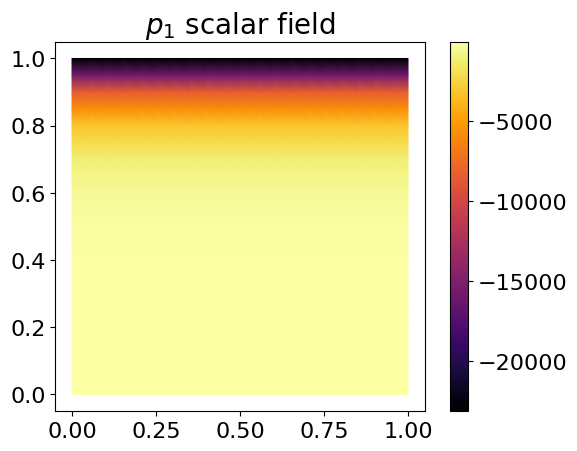

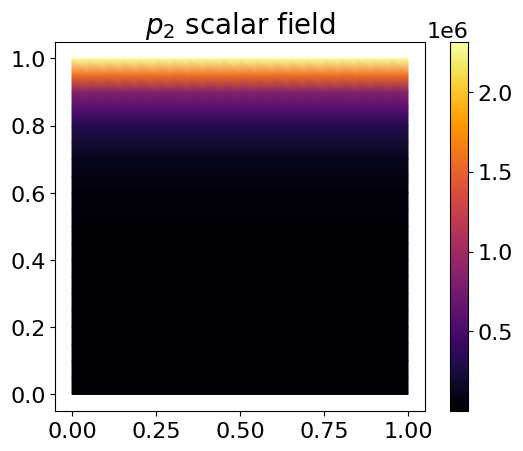

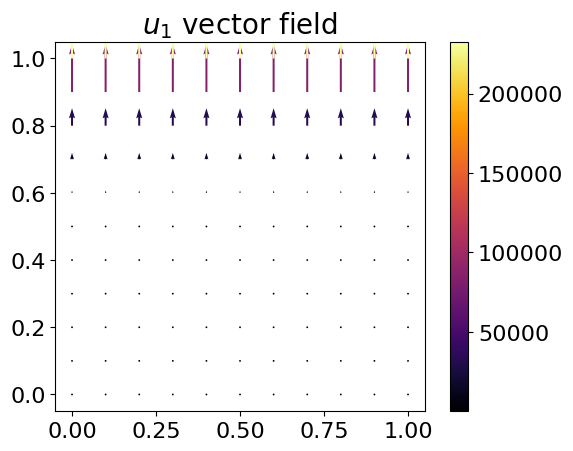

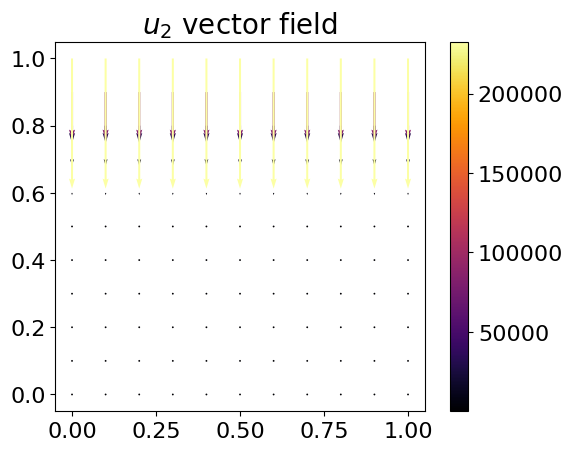

In [5]:
fig, axes = plt.subplots()
contours = fd.tripcolor(p1_exact, axes=axes, cmap="inferno")
axes.set_aspect("equal")
axes.set_title(r"$p_1$ scalar field")
fig.colorbar(contours)
plt.show()

fig, axes = plt.subplots()
contours = fd.tripcolor(p2_exact, axes=axes, cmap="inferno")
axes.set_aspect("equal")
axes.set_title(r"$p_2$ scalar field")
fig.colorbar(contours)
plt.show()

fig, axes = plt.subplots()
contours = fd.quiver(u1_exact, axes=axes, cmap="inferno")
axes.set_aspect("equal")
axes.set_title(r"$u_1$ vector field")
fig.colorbar(contours)
plt.show()

fig, axes = plt.subplots()
contours = fd.quiver(u2_exact, axes=axes, cmap="inferno")
axes.set_aspect("equal")
axes.set_title(r"$u_2$ vector field")
fig.colorbar(contours)
plt.show()

## Conforming Galerkin FEM approximations

### Monolithic (fully coupled) approximation

In [6]:
# Approximation degree
degree = 1

# Function space declaration
pressure_family = "CG"
velocity_family = "CG"
U = fd.VectorFunctionSpace(mesh, velocity_family, degree)
V = fd.FunctionSpace(mesh, pressure_family, degree)
W = V * V

# Trial and test functions
p1, p2 = fd.TrialFunctions(W)
q1, q2 = fd.TestFunctions(W)

# Forcing function
f = fd.Constant(0.0)

# Dirichlet BCs
bc_macro = fd.DirichletBC(W.sub(0), p1_exact, "on_boundary")
bc_micro = fd.DirichletBC(W.sub(1), p2_exact, "on_boundary")
bcs = [bc_macro, bc_micro]

# Variational form
## Mass transfer term
xi = -beta / mu * (p1 - p2)

## Macro terms
a = (k1 / mu) * inner(grad(p1), grad(q1)) * dx - xi * q1 * dx
L = f * q1 * dx

## Micro terms
a += (k2 / mu) * inner(grad(p2), grad(q2)) * dx + xi * q2 * dx
L += f * q2 * dx

# Solving the problem
solver_parameters = {
    "mat_type": "aij",
    "ksp_type": "preonly",
    "pc_type": "lu",
    "pc_factor_mat_solver_type": "mumps",
}
solution = fd.Function(W)
problem = fd.LinearVariationalProblem(a, L, solution, bcs=bcs, constant_jacobian=True)
solver = fd.LinearVariationalSolver(problem, solver_parameters=solver_parameters)
solver.solve()

# Retrieving the solution
p1_h = fd.Function(V, name="p1_h")
p2_h = fd.Function(V, name="p2_h")
p1_h.assign(solution.sub(0))
p2_h.assign(solution.sub(1))
u1_h = fd.project(-grad(p1_h), U)
u2_h = fd.project(-grad(p2_h), U)

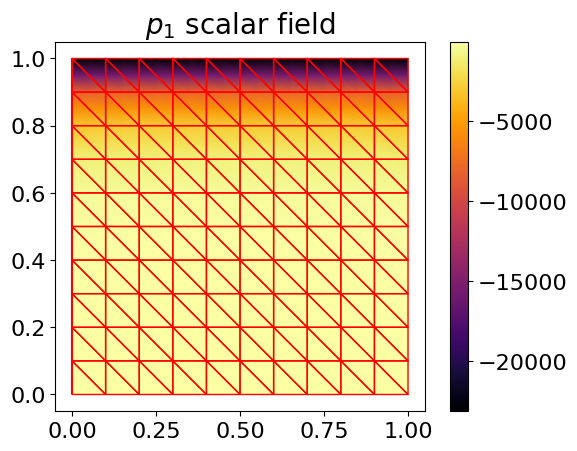

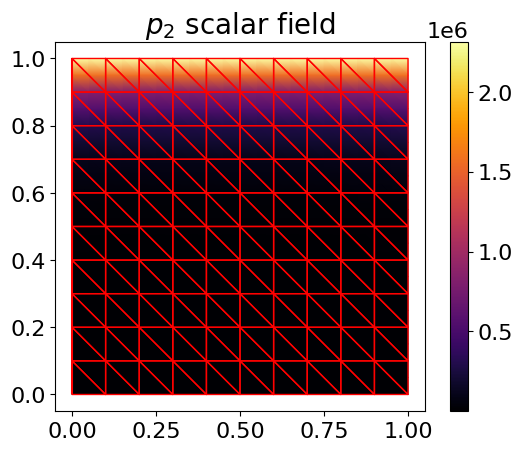

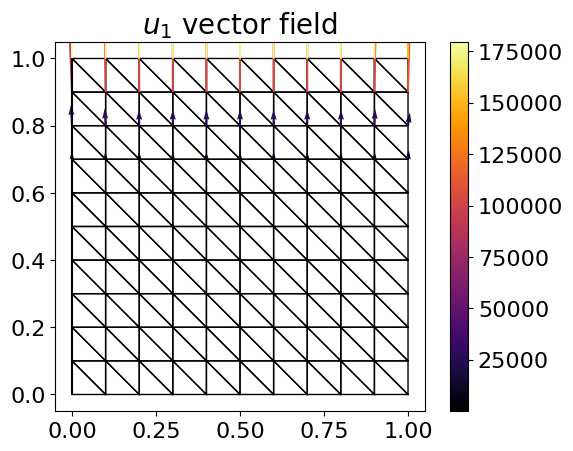

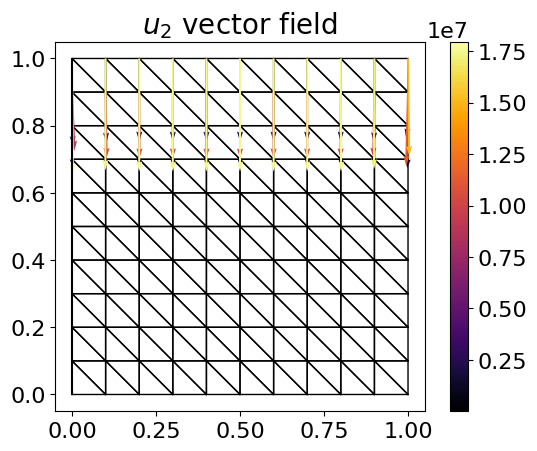

In [7]:
fig, axes = plt.subplots()
colors = fd.tripcolor(p1_h, axes=axes, cmap="inferno")
fd.triplot(mesh, axes=axes, interior_kw={"edgecolors": "red"}, boundary_kw={"colors": "red"})
axes.set_aspect("equal")
axes.set_title(r"$p_1$ scalar field")
fig.colorbar(colors)
plt.show()

fig, axes = plt.subplots()
colors = fd.tripcolor(p2_h, axes=axes, cmap="inferno")
fd.triplot(mesh, axes=axes, interior_kw={"edgecolors": "red"}, boundary_kw={"colors": "red"})
axes.set_aspect("equal")
axes.set_title(r"$p_2$ scalar field")
fig.colorbar(colors)
plt.show()

fig, axes = plt.subplots()
fd.triplot(mesh, axes=axes, boundary_kw={"colors": "k"})
colors = fd.quiver(u1_h, axes=axes, cmap="inferno")
axes.set_aspect("equal")
axes.set_title(r"$u_1$ vector field")
fig.colorbar(colors)
plt.show()

fig, axes = plt.subplots()
fd.triplot(mesh, axes=axes, boundary_kw={"colors": "k"})
colors = fd.quiver(u2_h, axes=axes, cmap="inferno")
axes.set_aspect("equal")
axes.set_title(r"$u_2$ vector field")
fig.colorbar(colors)
plt.show()